In [1]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/mssmartypants/rice-type-classification'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 695MB/s]

In [2]:
!pip install torchsummary

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
data_df = pd.read_csv('riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)

In [6]:
print(data_df["Class"].unique())

[1 0]


In [7]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [8]:
# prompt: use standard scaler on the dataframe copy

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
original_df = data_df.copy()

X = data_df.iloc[:, :-1]
y = data_df.iloc[:, -1]

cols = X.columns
X[cols] = scaler.fit_transform(X[cols])

X.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation
0,-1.703630,-4.803744,0.417927,-6.393938,-1.696989,-1.830049,0.391654,-2.661778,0.839588,-2.663800
1,-2.838478,-6.220789,-0.835611,-6.209583,-2.803539,-3.398143,0.923070,-4.857318,1.837215,-2.635418
2,-2.718519,-6.091404,-0.771700,-6.024520,-2.725641,-3.213879,1.365122,-4.799860,2.383587,-2.605950
3,-2.701479,-6.031573,-0.783130,-5.781578,-2.708996,-3.188141,1.598635,-4.777995,2.409877,-2.565690
4,-2.278893,-5.377799,-0.341288,-5.433479,-2.279559,-2.580390,1.463045,-4.111042,2.477331,-2.504645


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [10]:
class dataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32).to(device)
    self.y = torch.tensor(y.values, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [11]:
# Hyperparameter setting
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_NEURONS = 100
LR = 1e-3

In [12]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
train_dataloader

In [14]:
class MyModel(nn.Module):
  def __init__(self):

    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

In [15]:
model = MyModel().to(device)
summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]           1,100
            Linear-2                    [-1, 1]             101
           Sigmoid-3                    [-1, 1]               0
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [16]:
# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

In [17]:
# TRAINING
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in val_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      # print("Accuracy: ", acc)
      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

  print(f'''Epoch no. {epoch+1}:
  Training Loss: {round(total_loss_train/1000, 4)}
  Training Accuracy: {round(total_acc_train/(training_data.__len__())*100, 4)}%
  Validation Loss: {round(total_loss_val/1000, 4)}
  Validation Accuracy: {round(total_acc_val/(validation_data.__len__())*100, 4)}%
  ''')

  print('='*50)

Epoch no. 1:
  Training Loss: 0.0263
  Training Accuracy: 96.8261%
  Validation Loss: 0.0022
  Validation Accuracy: 98.607%
  
Epoch no. 2:
  Training Loss: 0.0092
  Training Accuracy: 98.5781%
  Validation Loss: 0.002
  Validation Accuracy: 98.3871%
  
Epoch no. 3:
  Training Loss: 0.0085
  Training Accuracy: 98.5938%
  Validation Loss: 0.0019
  Validation Accuracy: 98.607%
  
Epoch no. 4:
  Training Loss: 0.0082
  Training Accuracy: 98.6488%
  Validation Loss: 0.002
  Validation Accuracy: 98.4604%
  
Epoch no. 5:
  Training Loss: 0.0081
  Training Accuracy: 98.6409%
  Validation Loss: 0.0019
  Validation Accuracy: 98.4604%
  
Epoch no. 6:
  Training Loss: 0.008
  Training Accuracy: 98.7195%
  Validation Loss: 0.0017
  Validation Accuracy: 98.607%
  
Epoch no. 7:
  Training Loss: 0.0079
  Training Accuracy: 98.7352%
  Validation Loss: 0.0017
  Validation Accuracy: 98.6437%
  
Epoch no. 8:
  Training Loss: 0.0078
  Training Accuracy: 98.7587%
  Validation Loss: 0.0017
  Validation Accu

In [18]:
help(summary)

Help on function summary in module torchsummary.torchsummary:

summary(model, input_size, batch_size=-1, device='cuda')



In [19]:
# TESTING
with torch.no_grad():
  total_acc_test = 0
  total_loss_test = 0

  for data in test_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_test += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

  print(f'''Testing Loss: {round(total_loss_test/1000, 4)}
  Testing Accuracy: {round(total_acc_test/(testing_data.__len__())*100, 4)}%
  ''')

Testing Loss: 0.0011
  Testing Accuracy: 99.4135%
  


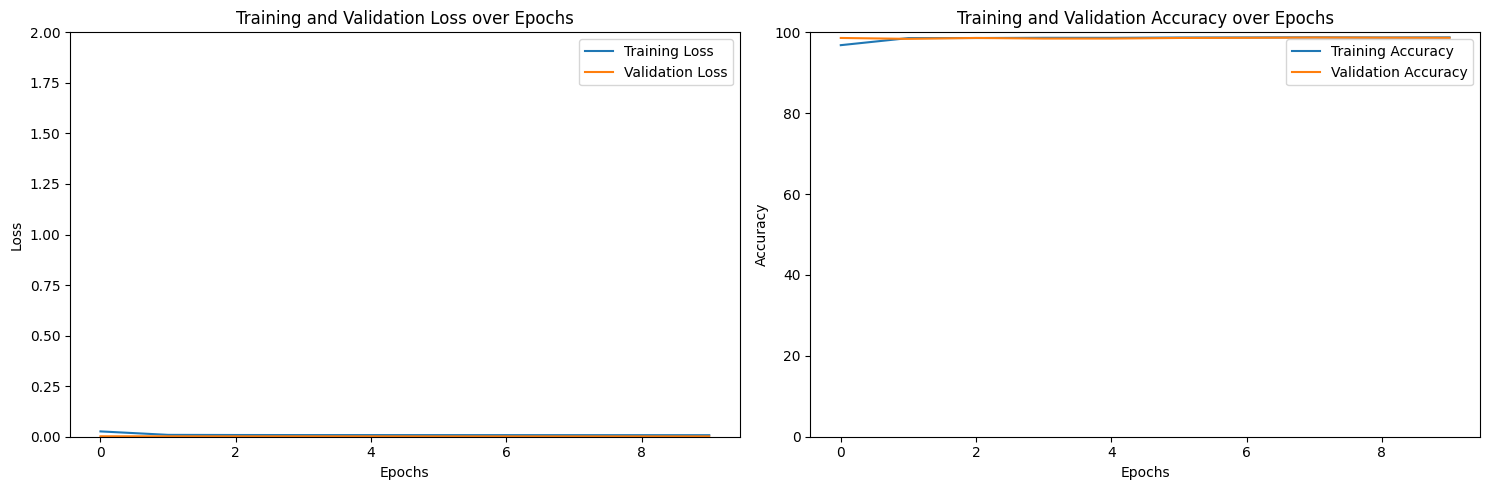

In [20]:
# Plotting and Visualizations
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()
plt.show()

In [21]:
desc = data_df.describe()
desc

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
count,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000
mean,7036.492989,151.680754,59.807851,0.915406,7225.817872,94.132952,0.616653,351.606949,0.707998,2.599081,0.549079
std,1467.197150,12.376402,10.061653,0.030575,1502.006571,9.906250,0.104389,29.500620,0.067310,0.434836,0.497599
min,2522.000000,74.133114,34.409894,0.676647,2579.000000,56.666658,0.383239,197.015000,0.174590,1.358128,0.000000
25%,5962.000000,145.675910,51.393151,0.891617,6125.000000,87.126656,0.538530,333.990000,0.650962,2.208527,0.000000
50%,6660.000000,153.883750,55.724288,0.923259,6843.000000,92.085696,0.601194,353.088000,0.701941,2.602966,1.000000
75%,8423.000000,160.056214,70.156593,0.941372,8645.000000,103.559146,0.695664,373.003000,0.769280,2.964101,1.000000
max,10210.000000,183.211434,82.550762,0.966774,11008.000000,114.016559,0.886573,508.511000,0.904748,3.911845,1.000000


In [22]:
type(desc.columns[0])

str

In [25]:
desc.columns[:-1]

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation'],
      dtype='object')

In [34]:
Area = float(input("Area: "))
MajorAxisLength = float(input("MajorAxisLength: "))
MinorAxisLength = float(input("MinorAxisLength: "))
Eccentricity = float(input("Eccentricity: "))
ConvexArea = float(input("ConvexArea: "))
EquivDiameter = float(input("EquivDiameter: "))
Extent = float(input("Extent: "))
Perimeter = float(input("Perimeter: "))
Roundness = float(input("Roundness: "))
AspectRation = float(input("AspectRation: "))

inputs = [Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]


for i, col in enumerate(desc.columns[:-1]):
    mean = desc.loc['mean', col]
    std = desc.loc['std', col]
    inputs[i] = (inputs[i] - mean) / std
    print(inputs[i])

print("="*20)
model_input = torch.tensor(inputs, dtype=torch.float32).to(device)
prediction = model(model_input)
print(prediction)
print("Class is: ", round(prediction.item()))


0.11144174540958504
0.26819151409861963
-0.17967735903963833
-0.17682192980929204
0.11596628900800555
0.08752530563098737
0.03206431081191869
0.2845042169084366
2.1096615683538396
0.1630932926722286
tensor([0.0067], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
